# Watertown, MA Rain and Wind analysis

In [1]:
import requests
import os
import numpy as np
import pandas as pd
import getweatherdata
import matplotlib.pyplot as plt
from ipywidgets import interact
import ipywidgets as widgets
from matplotlib.widgets import Slider, RangeSlider, CheckButtons
#the next two are not needed in newer versions of Jupyter, Python
from IPython.display import display
%matplotlib inline

In [2]:
#cannot use pd.read_csv because the file is not in the correct format
#use np.genfromtxt instead to read from fixed-width text file
#fields are unicode strings of prescribed length or double

stations = np.genfromtxt(os.getcwd()+'/stationdata.txt', delimiter=[11,9,10,7,3,31,4,4,6],
                                         names=['id','latitude','longitude','elevation','state','name',
                                                'gsn','hcn','wmo'],
                                         dtype=['U11','d','d','d','U3','U31','U4','U4','U6'],
                                         autostrip=True)

In [3]:
#find stations beginning with "Watertown" in Massachusetts
stations[np.logical_and(np.char.find(stations['name'],'WATERTOWN')==0,stations['state']=='MA')]

array([('US1MAMD0119', 42.3711, -71.1995, 16.5, 'MA', 'WATERTOWN 1.1 W', '', '', ''),
       ('US1MAMD0186', 42.3786, -71.1959, 36. , 'MA', 'WATERTOWN 1.1 NW', '', '', '')],
      dtype=[('id', '<U11'), ('latitude', '<f8'), ('longitude', '<f8'), ('elevation', '<f8'), ('state', '<U3'), ('name', '<U31'), ('gsn', '<U4'), ('hcn', '<U4'), ('wmo', '<U6')])

Both stations in Watertown, MA, are not in any of the quality-controlled large networks, so may only have limited data.

In [4]:
response=requests.get('https://www1.ncdc.noaa.gov/pub/data/ghcn/daily/all/US1MAMD0119.dly')
with open('WatertownW.dly', 'w') as file:
    file.write(response.text)

In [5]:
getweatherdata.dly_to_csv('WatertownW.dly','WATERTOWNW')

In [6]:
response=requests.get('https://www1.ncdc.noaa.gov/pub/data/ghcn/daily/all/US1MAMD0186.dly')
with open('WatertownNW.dly', 'w') as file:
    file.write(response.text)

In [7]:
getweatherdata.dly_to_csv('WatertownNW.dly','WATERTOWNNW')

The following are features of interest for WIND as per the [documentation](https://www1.ncdc.noaa.gov/pub/data/ghcn/daily/readme.txt):
* AWDR = Average daily wind direction (degrees)
* AWND = Average daily wind speed (tenths of meters per second)
* WDF1 = Direction of fastest 1-minute wind (degrees)
* WDF2 = Direction of fastest 2-minute wind (degrees)
* WDF5 = Direction of fastest 5-second wind (degrees)
* WDFG = Direction of peak wind gust (degrees)
* WDFI = Direction of highest instantaneous wind (degrees)
* WDFM = Fastest mile wind direction (degrees)
* WDMV = 24-hour wind movement (km or miles as per user preference, miles on Daily Form pdf file)
* WSF1 = Fastest 1-minute wind speed (miles per hour or meters per second as per user preference)
* WSF2 = Fastest 2-minute wind speed (miles per hour or meters per second as per user preference)
* WSF5 = Fastest 5-second wind speed (miles per hour or meters per second as per user preference)
* WSFG = Peak guest wind speed (miles per hour or meters per second as per user preference)
* WSFI = Highest instantaneous wind speed (miles per hour or meters per second as per user preference)
* WSFM = Fastest mile wind speed (miles per hour or meters per second as per user preference)

In [8]:
Watertown1=pd.read_csv('WATERTOWNW.csv')
Watertown1.head()

,STATION,DATE,PRCP,PRCP_ATTRIBUTES,SNOW,SNOW_ATTRIBUTES,SNWD,SNWD_ATTRIBUTES,WESD,WESD_ATTRIBUTES,WESF,WESF_ATTRIBUTES
0,US1MAMD0119,2018-05-03,0.0,",,N",0.0,",,N",0.0,",,N",0.0,",,N",0.0,",,N"
1,US1MAMD0119,2018-05-04,13.0,",,N",0.0,",,N",0.0,",,N",0.0,",,N",0.0,",,N"
2,US1MAMD0119,2018-05-05,3.0,",,N",0.0,",,N",0.0,",,N",0.0,",,N",0.0,",,N"
3,US1MAMD0119,2018-05-06,0.0,"T,,N",0.0,",,N",0.0,",,N",0.0,",,N",0.0,",,N"
4,US1MAMD0119,2018-05-07,71.0,",,N",0.0,",,N",0.0,",,N",0.0,",,N",0.0,",,N"


In [9]:
Watertown2=pd.read_csv('WATERTOWNNW.csv')
Watertown2.head()

,STATION,DATE,DAPR,DAPR_ATTRIBUTES,MDPR,MDPR_ATTRIBUTES,PRCP,PRCP_ATTRIBUTES,SNOW,SNOW_ATTRIBUTES,WESF,WESF_ATTRIBUTES
0,US1MAMD0186,2021-03-07,NaN,NaN,NaN,NaN,0.0,",,N",0.0,",,N",NaN,NaN
1,US1MAMD0186,2021-03-08,NaN,NaN,NaN,NaN,0.0,",,N",0.0,",,N",NaN,NaN
2,US1MAMD0186,2021-03-09,NaN,NaN,NaN,NaN,0.0,",,N",0.0,",,N",NaN,NaN
3,US1MAMD0186,2021-03-10,NaN,NaN,NaN,NaN,0.0,",,N",0.0,",,N",NaN,NaN
4,US1MAMD0186,2021-03-11,NaN,NaN,NaN,NaN,0.0,",,N",0.0,",,N",NaN,NaN


For wind data, find a nearby station that has more data. We try one that is part of the WMO (world meteorological organization).

In [10]:
#find stations beginning with 'BOSTON' in Massachusetts, one (Boston Logan) has a WMO ID
stations[np.logical_and(np.char.find(stations['name'],'BOSTON')==0,stations['state']=='MA')]

array([('US1MASF0001', 42.357 , -71.0671, 13.1, 'MA', 'BOSTON 0.5 WSW', '', '', ''),
       ('US1MASF0031', 42.2927, -71.1456, 54.6, 'MA', 'BOSTON 6.5 SW', '', '', ''),
       ('USC00190768', 42.35  , -71.0667,  5.2, 'MA', 'BOSTON', '', '', ''),
       ('USW00014739', 42.3606, -71.0097,  3.4, 'MA', 'BOSTON', '', '', '72509'),
       ('USW00094701', 42.35  , -71.0667,  6.1, 'MA', 'BOSTON CITY WSO', '', '', '')],
      dtype=[('id', '<U11'), ('latitude', '<f8'), ('longitude', '<f8'), ('elevation', '<f8'), ('state', '<U3'), ('name', '<U31'), ('gsn', '<U4'), ('hcn', '<U4'), ('wmo', '<U6')])

In [11]:
#find stations beginning with "CAMBRIDGE" in Massachusetts
stations[np.logical_and(np.char.find(stations['name'],'CAMBRIDGE')==0,stations['state']=='MA')]

array([('US1MAMD0011', 42.3876, -71.1253, 14.6, 'MA', 'CAMBRIDGE 0.9 NNW', '', '', ''),
       ('US1MAMD0151', 42.3644, -71.1087,  5.2, 'MA', 'CAMBRIDGE 0.9 SSE', '', '', ''),
       ('USC00191097', 42.3833, -71.1167, 18. , 'MA', 'CAMBRIDGE', '', '', ''),
       ('USC00191099', 42.3833, -71.1   ,  2.4, 'MA', 'CAMBRIDGE "B"', '', '', ''),
       ('USC00191103', 42.375 , -71.1056,  4. , 'MA', 'CAMBRIDGE "C"', '', '', ''),
       ('USC00191110', 42.3667, -71.1   ,  5.8, 'MA', 'CAMBRIDGE MIT', '', '', '')],
      dtype=[('id', '<U11'), ('latitude', '<f8'), ('longitude', '<f8'), ('elevation', '<f8'), ('state', '<U3'), ('name', '<U31'), ('gsn', '<U4'), ('hcn', '<U4'), ('wmo', '<U6')])

In [12]:
#the Cambridge stations do not have a WMO id, so we will stick with Boston Logan
response=requests.get('https://www1.ncdc.noaa.gov/pub/data/ghcn/daily/all/USW00014739.dly')
with open('BostonLogan.dly', 'w') as file:
    file.write(response.text)
getweatherdata.dly_to_csv('BostonLogan.dly','BOSTONLOGAN')

In [13]:
BostonLogan=pd.read_csv('BOSTONLOGAN.csv',low_memory=False) #low_memory=False suppresses a warning about mixed data types in columns 
BostonLogan.head()

,STATION,DATE,ACMH,ACMH_ATTRIBUTES,ACSH,ACSH_ATTRIBUTES,ADPT,ADPT_ATTRIBUTES,ASLP,ASLP_ATTRIBUTES,...,WT17,WT17_ATTRIBUTES,WT18,WT18_ATTRIBUTES,WT19,WT19_ATTRIBUTES,WT21,WT21_ATTRIBUTES,WT22,WT22_ATTRIBUTES
0,USW00014739,1936-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,USW00014739,1936-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,1.0,",,X",NaN,NaN,NaN,NaN,NaN,NaN
2,USW00014739,1936-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,USW00014739,1936-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,USW00014739,1936-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,1.0,",,X",NaN,NaN,NaN,NaN,NaN,NaN


## Filtering Data

Now, trim down the columns to include only precipitation, temperature, and wind data.

In [14]:
#filter data for wind direction and speed, as well as temperature, from Boston Logan weather station
cols=list(BostonLogan.columns.values)
cols

['STATION',
 'DATE',
 'ACMH',
 'ACMH_ATTRIBUTES',
 'ACSH',
 'ACSH_ATTRIBUTES',
 'ADPT',
 'ADPT_ATTRIBUTES',
 'ASLP',
 'ASLP_ATTRIBUTES',
 'ASTP',
 'ASTP_ATTRIBUTES',
 'AWBT',
 'AWBT_ATTRIBUTES',
 'AWND',
 'AWND_ATTRIBUTES',
 'FMTM',
 'FMTM_ATTRIBUTES',
 'FRGT',
 'FRGT_ATTRIBUTES',
 'PGTM',
 'PGTM_ATTRIBUTES',
 'PRCP',
 'PRCP_ATTRIBUTES',
 'PSUN',
 'PSUN_ATTRIBUTES',
 'RHAV',
 'RHAV_ATTRIBUTES',
 'RHMN',
 'RHMN_ATTRIBUTES',
 'RHMX',
 'RHMX_ATTRIBUTES',
 'SNOW',
 'SNOW_ATTRIBUTES',
 'SNWD',
 'SNWD_ATTRIBUTES',
 'TAVG',
 'TAVG_ATTRIBUTES',
 'THIC',
 'THIC_ATTRIBUTES',
 'TMAX',
 'TMAX_ATTRIBUTES',
 'TMIN',
 'TMIN_ATTRIBUTES',
 'TSUN',
 'TSUN_ATTRIBUTES',
 'WDF1',
 'WDF1_ATTRIBUTES',
 'WDF2',
 'WDF2_ATTRIBUTES',
 'WDF5',
 'WDF5_ATTRIBUTES',
 'WDFG',
 'WDFG_ATTRIBUTES',
 'WDFM',
 'WDFM_ATTRIBUTES',
 'WESD',
 'WESD_ATTRIBUTES',
 'WSF1',
 'WSF1_ATTRIBUTES',
 'WSF2',
 'WSF2_ATTRIBUTES',
 'WSF5',
 'WSF5_ATTRIBUTES',
 'WSFG',
 'WSFG_ATTRIBUTES',
 'WSFM',
 'WSFM_ATTRIBUTES',
 'WT01',
 'WT01_ATTRIB

In [15]:
mask=list(pd.Series(cols).str.match('^(AW|WD|WS|TM)[^B]\w{1}$')) #columns starting AW, WD, WS, or TM, not followed by B,
#4 characters only (so no flag columns)
cols=[col for i,col in enumerate(cols) if mask[i]]
cols

['AWND',
 'TMAX',
 'TMIN',
 'WDF1',
 'WDF2',
 'WDF5',
 'WDFG',
 'WDFM',
 'WSF1',
 'WSF2',
 'WSF5',
 'WSFG',
 'WSFM']

In [16]:
#now restrict the columns to cols+identifiers, and restrict the date range
BostonLogan=BostonLogan[['STATION','DATE']+cols]
BostonLogan=BostonLogan[BostonLogan['DATE']>='2022-01-01']
#keep only columns which have at least one non-null entry
BostonLogan=BostonLogan[BostonLogan.columns[BostonLogan.notnull().sum()>0]]
BostonLogan.head(20)

,STATION,DATE,AWND,TMAX,TMIN,WDF2,WDF5,WSF2,WSF5
31412,USW00014739,2022-01-01,15.0,111.0,67.0,120.0,120.0,36.0,49.0
31413,USW00014739,2022-01-02,40.0,78.0,6.0,310.0,320.0,103.0,130.0
31414,USW00014739,2022-01-03,63.0,6.0,-60.0,20.0,330.0,89.0,121.0
31415,USW00014739,2022-01-04,44.0,-5.0,-82.0,310.0,330.0,76.0,98.0
31416,USW00014739,2022-01-05,50.0,106.0,-27.0,180.0,180.0,107.0,161.0
31417,USW00014739,2022-01-06,48.0,61.0,0.0,290.0,300.0,98.0,125.0
31418,USW00014739,2022-01-07,60.0,6.0,-49.0,280.0,270.0,103.0,130.0
31419,USW00014739,2022-01-08,48.0,-21.0,-82.0,310.0,330.0,103.0,134.0
31420,USW00014739,2022-01-09,72.0,61.0,-60.0,230.0,230.0,143.0,197.0
31421,USW00014739,2022-01-10,75.0,44.0,-55.0,280.0,280.0,112.0,161.0


In [17]:
#date restrict df1 and df2, and restrict the columns to station, date, precipitation, and snow
Watertown1=Watertown1[Watertown1['DATE']>='2022-01-01']
Watertown1=Watertown1[['STATION','DATE','PRCP','SNOW']]
Watertown2=Watertown2[Watertown2['DATE']>='2022-01-01']
Watertown2=Watertown2[['STATION','DATE','PRCP','SNOW']]

In [18]:
Watertown1.head(20) #precipitation is given in tenths of mm

,STATION,DATE,PRCP,SNOW
1328,US1MAMD0119,2022-01-01,5.0,0.0
1329,US1MAMD0119,2022-01-02,76.0,0.0
1330,US1MAMD0119,2022-01-03,8.0,0.0
1331,US1MAMD0119,2022-01-04,0.0,0.0
1332,US1MAMD0119,2022-01-05,0.0,0.0
1333,US1MAMD0119,2022-01-06,76.0,0.0
1334,US1MAMD0119,2022-01-07,79.0,170.0
1335,US1MAMD0119,2022-01-08,51.0,43.0
1336,US1MAMD0119,2022-01-09,0.0,0.0
1337,US1MAMD0119,2022-01-10,3.0,NaN


In [19]:
Watertown2.head() #we see here that missing dates can occur (Jan 5, 2022 is missing), so need to take care of mapping dates correctly

,STATION,DATE,PRCP,SNOW
270,US1MAMD0186,2022-01-01,3.0,NaN
271,US1MAMD0186,2022-01-02,81.0,NaN
272,US1MAMD0186,2022-01-03,5.0,NaN
273,US1MAMD0186,2022-01-04,0.0,0.0
274,US1MAMD0186,2022-01-06,71.0,NaN


## Plotting Data

### Quick plots

Plot temperature, precipitation, highlight special wind events (wind coming from ENE to ESE).

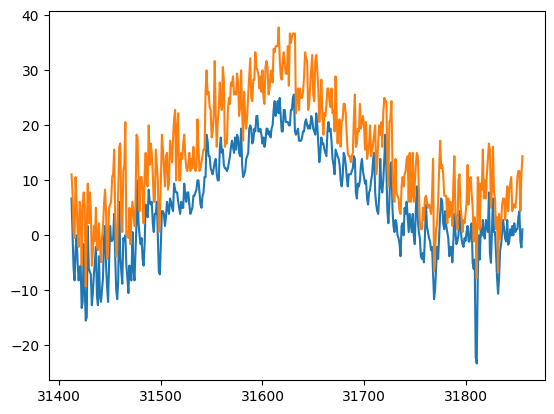

In [20]:
#first quick plot of the temperature ... only important to gauge snowfall vs rain
plt.plot(BostonLogan['TMIN']/10)
plt.plot(BostonLogan['TMAX']/10)

<BarContainer object of 442 artists>

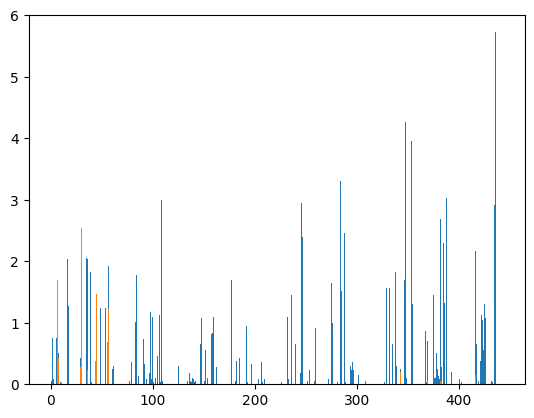

In [21]:
#first quick plot of precipitation/rain and snow in cm
days=np.arange(1,len(Watertown1)+1)
plt.bar(days,Watertown1['PRCP']/100)
plt.bar(days,Watertown1['SNOW']/100)

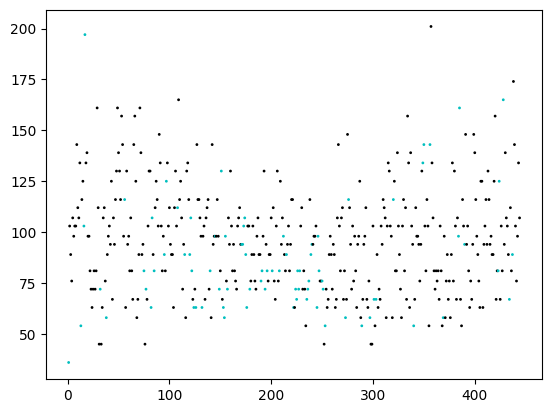

In [22]:
#first quick plot of wind speed, highlighting wind coming from ENE to ESE directions (60 to 120 degrees from true North)
days=np.arange(1,len(BostonLogan)+1)
col=np.where((BostonLogan['WDF2']>=60) & (BostonLogan['WDF2']<=120),'c','k')
plt.scatter(days,BostonLogan['WSF2'],c=col,s=1)

### Detailed plots

In [23]:
#indexing by date
Watertown1.index=pd.DatetimeIndex(Watertown1.DATE)
Watertown2.index=pd.DatetimeIndex(Watertown2.DATE)
BostonLogan.index=pd.DatetimeIndex(BostonLogan.DATE)

In [24]:
#reindex, filling in missing dates, so that all dataframes have the same index (NOW we have new objects with np.NaN filled)
today=pd.to_datetime('today').date()
Watertown1=Watertown1.reindex(pd.date_range("2022-01-01", today))
Watertown2=Watertown2.reindex(pd.date_range("2022-01-01", today))
BostonLogan=BostonLogan.reindex(pd.date_range("2022-01-01", today))

In [25]:
Watertown2.head()

,STATION,DATE,PRCP,SNOW
2022-01-01,US1MAMD0186,2022-01-01,3.0,NaN
2022-01-02,US1MAMD0186,2022-01-02,81.0,NaN
2022-01-03,US1MAMD0186,2022-01-03,5.0,NaN
2022-01-04,US1MAMD0186,2022-01-04,0.0,0.0
2022-01-05,NaN,NaN,NaN,NaN


In [26]:
BostonLogan.tail() #there appears to be a several day lag in publishing the latest data

,STATION,DATE,AWND,TMAX,TMIN,WDF2,WDF5,WSF2,WSF5
2023-03-20,USW00014739,2023-03-20,58.0,111.0,-22.0,230.0,250.0,107.0,134.0
2023-03-21,USW00014739,2023-03-21,NaN,144.0,11.0,NaN,NaN,NaN,NaN
2023-03-22,USW00014739,2023-03-22,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-03-23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-03-24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


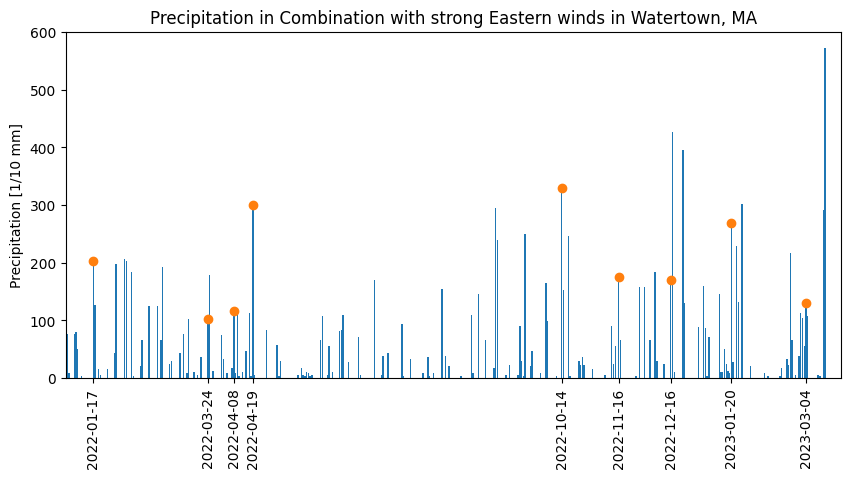

In [27]:
plt.figure(figsize=(10,4.5))
threshw=100 #wind threshold
threshr=100 #rain threshold
dirmin=60
dirmax=140
mask=((BostonLogan['WDF2']>=dirmin) & (BostonLogan['WDF2']<=dirmax) & (BostonLogan['WSF2']>=threshw)
      & ((Watertown1['PRCP']>=threshr) | (Watertown2['PRCP']>=threshr)))
plt.bar(Watertown1.index, Watertown1['PRCP'])
plt.scatter(BostonLogan.loc[mask].index,Watertown1.loc[mask]['PRCP'],marker='o')
plt.axis(xmin=pd.to_datetime('2022-01-01').date(),xmax=pd.to_datetime('today').date())
plt.ylabel('Precipitation [1/10 mm]')
plt.xticks(BostonLogan.loc[mask].index,rotation=90)
plt.title('Precipitation in Combination with strong Eastern winds in Watertown, MA');

In [28]:
BostonLogan.loc[mask], Watertown1.loc[mask], Watertown2.loc[mask]
#we see the rainfall amounts are generally similar between the two Watertown stations, 
#and the average wind speed vs fastest 2-min wind (WSF2) gives us an
#idea about which days have sustained strong winds

(                STATION        DATE   AWND   TMAX   TMIN   WDF2   WDF5   WSF2  \
 2022-01-17  USW00014739  2022-01-17  107.0   94.0   17.0  100.0  120.0  197.0   
 2022-03-24  USW00014739  2022-03-24   75.0   61.0   39.0  110.0  110.0  107.0   
 2022-04-08  USW00014739  2022-04-08   55.0  172.0   67.0  130.0  120.0  134.0   
 2022-04-19  USW00014739  2022-04-19   97.0  150.0   61.0  130.0   80.0  165.0   
 2022-10-14  USW00014739  2022-10-14   44.0  206.0  139.0  130.0  130.0  125.0   
 2022-11-16  USW00014739  2022-11-16   67.0  139.0   28.0  100.0  280.0  116.0   
 2022-12-16  USW00014739  2022-12-16  110.0   72.0   56.0   70.0   60.0  143.0   
 2023-01-20  USW00014739  2023-01-20   45.0   33.0   -5.0   60.0   60.0  161.0   
 2023-03-04  USW00014739  2023-03-04   93.0   28.0   -6.0   80.0   90.0  165.0   
 
              WSF5  
 2022-01-17  250.0  
 2022-03-24  130.0  
 2022-04-08  170.0  
 2022-04-19  206.0  
 2022-10-14  157.0  
 2022-11-16  152.0  
 2022-12-16  183.0  
 2023-01-2

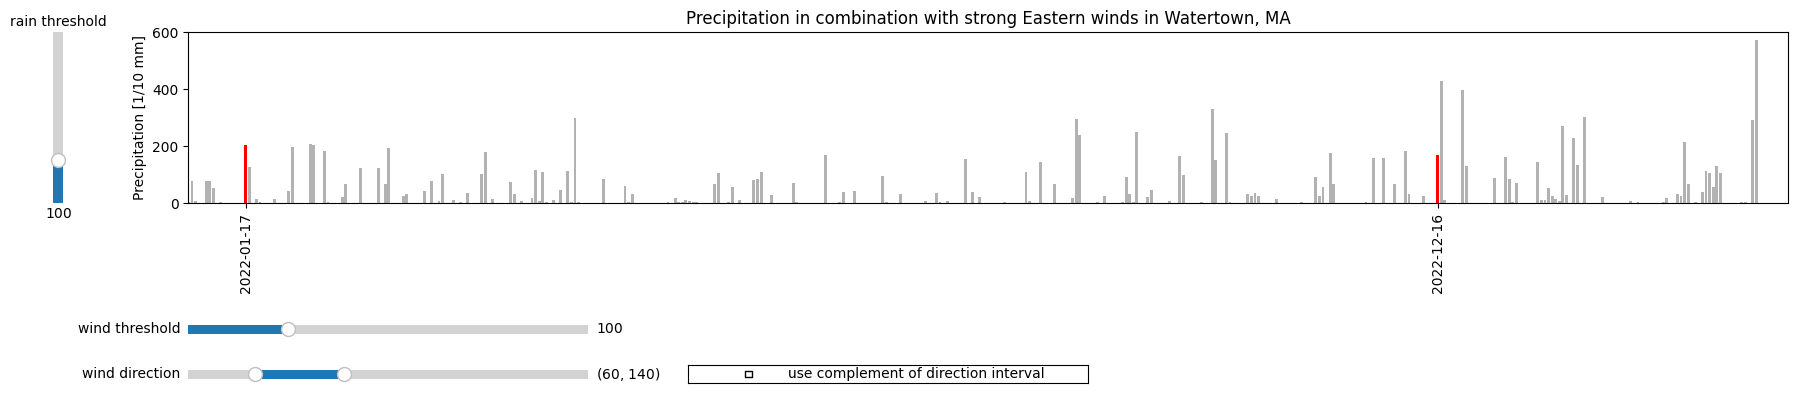

In [29]:
#%matplotlib notebook
#uncomment the above to have interactive output (functional sliders, etc.) for this cell, or simply run the next cell

#initialize plot
fig,ax=plt.subplots(figsize=(20,4.5))

ax.set_ylabel('Precipitation [1/10 mm]')
ax.set_title('Precipitation in combination with strong Eastern winds in Watertown, MA')
ax.set_xlim(xmin=pd.to_datetime('2022-01-01').date(),xmax=pd.to_datetime('today').date())
plt.setp(ax.get_xticklabels(),rotation=90)

dirmin_init=60
dirmax_init=140
threshr_init=100
threshw_init=100
mask=((BostonLogan['WDF2']>=dirmin_init) & (BostonLogan['WDF2']<=dirmax_init) & (BostonLogan['AWND']>=threshw_init) & (Watertown1['PRCP']>=threshr_init))
col=np.where(mask,'r','k')
bars=ax.bar(Watertown1.index,Watertown1['PRCP'],color=col)#initialize bar plot with colored bars
for i in range(len(bars)): #also adjust opacity
    if mask[i]:
        bars[i].set(alpha=1)
    else:
        bars[i].set(alpha=0.3)
ticks=ax.set_xticks(BostonLogan.loc[mask].index)#point out colored bars with tick labels
#plt.show()

#plot update function
def weatherplot(threshr,threshw,direction,complement):
    #use AWND to gauge sustained strong wind
    mask= (BostonLogan['AWND']>=threshw) & (Watertown1['PRCP']>=threshr)
    if complement:
        mask=mask&((BostonLogan['WDF2']<=direction[0]) | (BostonLogan['WDF2']>=direction[1]))
    else:
        mask=mask&(BostonLogan['WDF2']>=direction[0]) & (BostonLogan['WDF2']<=direction[1])
    for i in range(len(bars)):
        if mask[i]:
            bars[i].set(color='r',alpha=1)
        else:
            bars[i].set(color='k',alpha=0.3)
    ticks=ax.set_xticks(BostonLogan.loc[mask].index)
    fig.canvas.draw_idle()

#make room for the sliders
fig.subplots_adjust(left=0.1, bottom=0.5)

#create new axes, sliders, and checkbox
axr=fig.add_axes([0.03, 0.5, 0.01, 0.38])
r_slider=Slider(ax=axr,valinit=threshr_init,valmin=0,valmax=400,label='rain threshold',orientation='vertical')
axw=fig.add_axes([0.1, 0.2, 0.2, 0.04])
w_slider=Slider(ax=axw,valinit=threshw_init,valmin=0,valmax=400,label='wind threshold')
axd=fig.add_axes([0.1, 0.1, 0.2, 0.04])
d_slider=RangeSlider(ax=axd,valinit=[dirmin_init,dirmax_init],valmin=0,valmax=360,label='wind direction')
axc=fig.add_axes([0.35, 0.1, 0.2, 0.04])
c_box=CheckButtons(ax=axc,labels=['use complement of direction interval'])

#update function accepts exactly one (dummy) argument
def update(arg):
    weatherplot(r_slider.val,w_slider.val,d_slider.val,c_box.get_status()[0]) 
    #vals of sliders and the status of the first (and only) checkbutton passed to the actual update function weatherplot()

#register sliders and checkbox with the update function
r_slider.on_changed(update)
w_slider.on_changed(update)
d_slider.on_changed(update)
c_box.on_clicked(update);

In [30]:
#%matplotlib inline
#run the notebook in order to use the widgets and see the output
fig,ax=plt.subplots(figsize=(20,4.5))

ax.set_ylabel('Precipitation [1/10 mm]')
ax.set_title('Precipitation in combination with strong Eastern winds in Watertown, MA')
ax.set_xlim(xmin=pd.to_datetime('2022-01-01').date(),xmax=pd.to_datetime('today').date())
plt.setp(ax.get_xticklabels(),rotation=90)
#plt.setp(ax,visible=False) #this only makes the first plot "blank", but doesn't stop it from appearing

bars=ax.bar(Watertown1.index,Watertown1['PRCP'])#initialize bar plot
plt.close(fig)#don't show figure (yet), stops first plot from appearing

#plot update function
def weatherplot(threshr,threshw,direction,complement):
    #plt.clf() #does not remove the plot drawn outside of this function
    #use AWND to gauge sustained strong wind
    mask= (BostonLogan['AWND']>=threshw) & (Watertown1['PRCP']>=threshr)
    if complement:
        mask&=((BostonLogan['WDF2']<=direction[0]) | (BostonLogan['WDF2']>=direction[1]))
    else:
        mask&=(BostonLogan['WDF2']>=direction[0]) & (BostonLogan['WDF2']<=direction[1])
    for i in range(len(bars)):
        if mask[i]:
            bars[i].set(color='r',alpha=1)
        else:
            bars[i].set(color='k',alpha=0.3)
    ticks=ax.set_xticks(BostonLogan.loc[mask].index)
    #plt.show() ... does not seem to do the trick
    #fig.canvas.draw_idle() ... does not seem to do the trick
    display(fig)
    #return fig#same effect as display(), this redraws the figure below, but it doesn't close/update the figure if drawn outside this function

r_slider=widgets.IntSlider(value=100,min=0,max=400,step=1, description='rain threshold', continuous_update=False)
w_slider=widgets.IntSlider(value=100,min=0,max=400,step=1,description='wind threshold', continuous_update=False)
d_slider=widgets.IntRangeSlider(value=[60,140],min=0,max=360,step=1,description='wind direction', continuous_update=False)
c_box=widgets.Checkbox(value=False,description='use complement of direction interval',disabled=False,indent=False)


interact(weatherplot,threshr=r_slider,threshw=w_slider,direction=d_slider,complement=c_box);


interactive(children=(IntSlider(value=100, continuous_update=False, description='rain threshold', max=400), In…